In [32]:
from hossam import *
from pandas import DataFrame, Series, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product
from scipy.spatial import ConvexHull


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 성능 평가 지표 모듈
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)


import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import (
    hs_get_scores,
    hs_learning_cv,
    hs_get_score_cv,
    feature_importance,
    hs_shap_analysis,
)

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)

In [33]:
origin = load_data("dogs")
origin.head()

닥스훈트와 진돗개의 몸 길이와 키를 조사한 가상 데이터


,dog,length,height
0,d,55.010,29.270
1,d,59.010,29.390
2,d,56.530,28.500
3,d,53.660,28.500
4,d,49.670,31.970


In [34]:
df = origin.astype({"dog": "category"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   dog     200 non-null    category
 1   length  200 non-null    float64 
 2   height  200 non-null    float64 
dtypes: category(1), float64(2)
memory usage: 3.6 KB


In [35]:
def hs_describe(data, columns=None):
    num_columns = list(data.select_dtypes(include=np.number).columns)

    if not columns:
        columns = num_columns

    # 기술통계량 구하기
    desc = data[columns].describe().T

    # 각 컬럼별 결측치 수(na_count) 추가
    na_counts = data[columns].isnull().sum()
    desc.insert(1, "na_count", na_counts)

    # 결측치 비율(na_rate) 추가
    desc.insert(2, "na_rate", (na_counts / len(data)) * 100)

    # 추가 통계량 계산
    additional_stats = []
    for f in columns:
        # 숫자 타입이 아니면 건너뜀
        if f not in num_columns:
            continue

        # 사분위수
        q1 = data[f].quantile(q=0.25)
        q3 = data[f].quantile(q=0.75)

        # 이상치 경계 (Tukey's fences)
        iqr = q3 - q1

        down = q1 - 1.5 * iqr
        up = q3 + 1.5 * iqr

        # 왜도
        skew = data[f].skew()

        # 이상치 개수 및 비율
        outlier_count = ((data[f] < down) | (data[f] > up)).sum()
        outlier_rate = (outlier_count / len(data)) * 100

        # 분포 특성 판정 (왜도 기준)
        abs_skew = abs(skew)
        if abs_skew < 0.5:
            dist = "거의 대칭"
        elif abs_skew < 1.0:
            if skew > 0:
                dist = "약간 우측 꼬리"
            else:
                dist = "약간 좌측 꼬리"
        elif abs_skew < 2.0:
            if skew > 0:
                dist = "중간 우측 꼬리"
            else:
                dist = "중간 좌측 꼬리"
        else:
            if skew > 0:
                dist = "극단 우측 꼬리"
            else:
                dist = "극단 좌측 꼬리"

        # 로그변환 필요성 판정
        if abs_skew < 0.5:
            log_need = "낮음"
        elif abs_skew < 1.0:
            log_need = "중간"
        else:
            log_need = "높음"

        additional_stats.append(
            {
                "field": f,
                "iqr": iqr,
                "up": up,
                "down": down,
                "outlier_count": outlier_count,
                "outlier_rate": outlier_rate,
                "skew": skew,
                "dist": dist,
                "log_need": log_need,
            }
        )

    additional_df = DataFrame(additional_stats).set_index("field")

    # 결과 병합
    result = concat([desc, additional_df], axis=1)

    return result

In [36]:
hs_describe(df).T

,length,height
count,200.000,200.000
na_count,0,0
na_rate,0.000,0.000
mean,53.795,41.675
std,5.506,10.036
min,39.940,22.760
25%,50.222,31.965
50%,53.445,43.785
75%,56.900,51.185
max,68.310,55.870


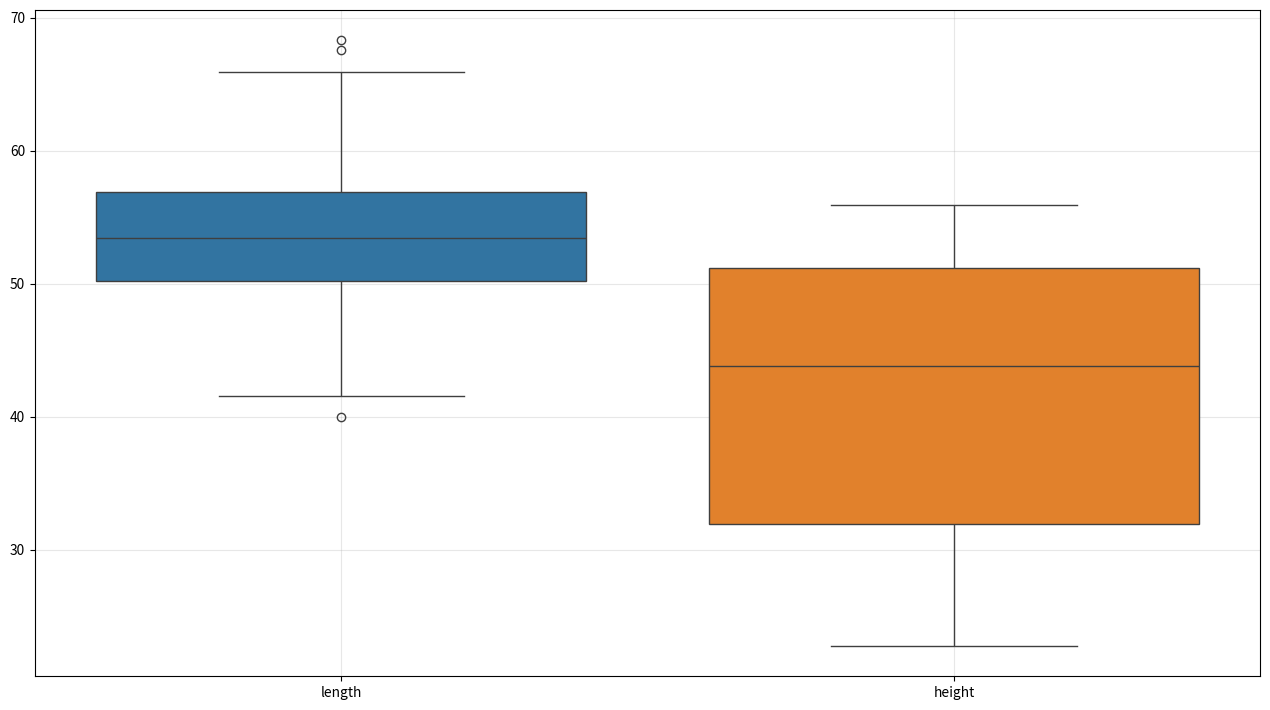

In [37]:
my_dpi = 100
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=origin, orient="v")

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [38]:
def category_describe(data, columns=None):
    num_columns = data.select_dtypes(include=np.number).columns

    if not columns:
        # 명목형(범주형) 컬럼 선택: object, category, bool 타입
        columns = data.select_dtypes(include=["object", "category", "bool"]).columns  # type: ignore

    result = []
    summary = []
    for f in columns:
        # 숫자형 컬럼은 건너뜀
        if f in num_columns:
            continue

        # 각 범주의 빈도수 계산 (NaN 포함)
        value_counts = data[f].value_counts(dropna=False)

        # 범주별 빈도/비율 정보 추가 (category_table 기능)
        for category, count in value_counts.items():
            rate = (count / len(data)) * 100
            result.append(
                {"변수": f, "범주": category, "빈도": count, "비율(%)": round(rate, 2)}
            )

        if len(value_counts) == 0:
            continue

        # 최다/최소 범주 정보 추가 (category_describe 기능)
        max_category = value_counts.index[0]
        max_count = value_counts.iloc[0]
        max_rate = (max_count / len(data)) * 100
        min_category = value_counts.index[-1]
        min_count = value_counts.iloc[-1]
        min_rate = (min_count / len(data)) * 100
        summary.append(
            {
                "변수": f,
                "최다_범주": max_category,
                "최다_비율(%)": round(max_rate, 2),
                "최소_범주": min_category,
                "최소_비율(%)": round(min_rate, 2),
            }
        )

    return DataFrame(result), DataFrame(summary).set_index("변수")

In [39]:
a, b = category_describe(df)
display(a)
display(b)

,변수,범주,빈도,비율(%)
0,dog,d,100,50.000
1,dog,j,100,50.000


,최다_범주,최다_비율(%),최소_범주,최소_비율(%)
변수,,,,
dog,d,50.000,j,50.000


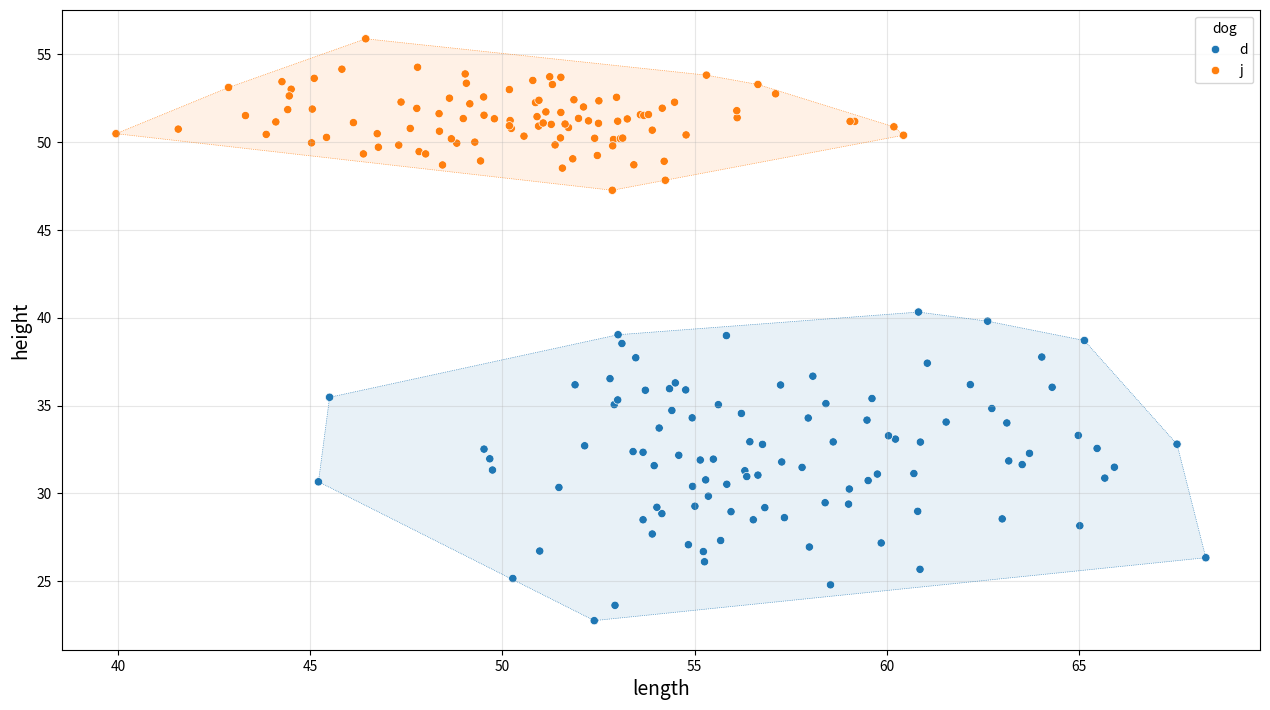

In [40]:
vdf = df.copy()
hue_field = "dog"
x_field = "length"
y_field = "height"
my_dpi = 100

figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 군집별, 값의 종류별로 반복
for c in vdf[hue_field].unique():
    # 값의 종류별로 데이터프레임을 나눔
    df_c = vdf.loc[vdf[hue_field] == c, [x_field, y_field]]

    try:
        hull = ConvexHull(df_c)  # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points = np.append(hull.vertices, hull.vertices[0])  # 시작점과 끝점을 연결
        ax.plot(
            df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=":"
        )
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)
ax.grid(True, alpha=0.3)  # 배경 격자 표시
plt.tight_layout()

plt.show()
plt.close()

In [41]:
df2 = df.copy()
df2["dog"] = df2["dog"].map({"d": 0, "j": 1})
display(df2.head())
df2.info()

,dog,length,height
0,0,55.010,29.270
1,0,59.010,29.390
2,0,56.530,28.500
3,0,53.660,28.500
4,0,49.670,31.970


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   dog     200 non-null    category
 1   length  200 non-null    float64 
 2   height  200 non-null    float64 
dtypes: category(1), float64(2)
memory usage: 3.6 KB


In [42]:
df3 = df2
yname = "dog"
x = df3.drop(columns=[yname])
y = df3[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((150, 2), (50, 2), (150,), (50,))

In [43]:
pipe = Pipeline(
    [
        ("VIF_Selector", VIFSelector()),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=52)),
    ]
)

param_grid = {
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__max_iter": [100, 300, 500],
    "model__class_weight": [None, "balanced"],
}

gs = GridSearchCV(
    estimator=pipe, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)

gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.01, random_state=52))])

In [44]:
y_pred = estimator.predict(x_test)
y_pred

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1])

In [45]:
df4 = x_test.copy()
df4["y_test"] = y_test
df4["y_pred"] = y_pred
df4.head()

,length,height,y_test,y_pred
119,54.480,52.260,1,1
62,59.030,30.250,0,0
132,55.310,53.800,1,1
114,42.870,53.100,1,1
104,56.110,51.380,1,1


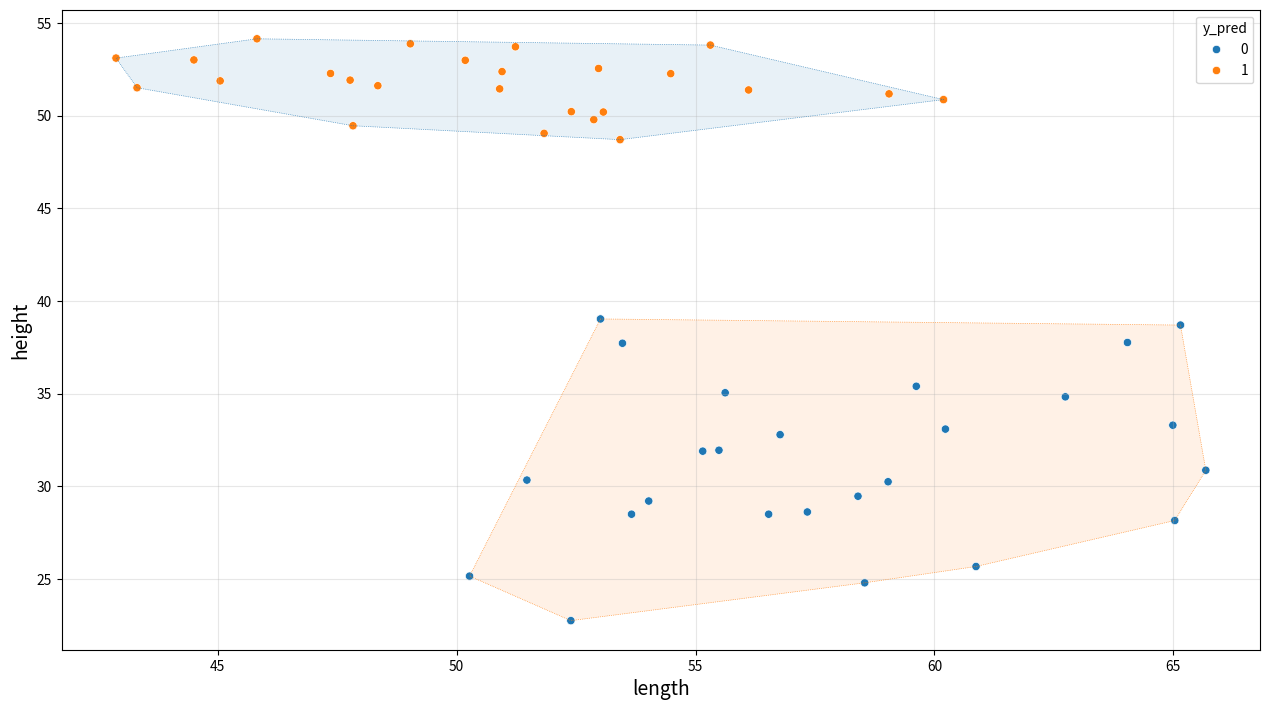

In [46]:
vdf = df4.copy()
hue_field = "y_pred"
x_field = "length"
y_field = "height"
my_dpi = 100

figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 군집별, 값의 종류별로 반복
for c in vdf[hue_field].unique():
    # 값의 종류별로 데이터프레임을 나눔
    df_c = vdf.loc[vdf[hue_field] == c, [x_field, y_field]]

    try:
        hull = ConvexHull(df_c)  # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points = np.append(hull.vertices, hull.vertices[0])  # 시작점과 끝점을 연결
        ax.plot(
            df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=":"
        )
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)
ax.grid(True, alpha=0.3)  # 배경 격자 표시
plt.tight_layout()

plt.show()
plt.close()

In [47]:
input_df = DataFrame({"length": [47, 39, 52], "height": [23, 42, 49]})

input_df["y_pred"] = estimator.predict(input_df)
input_df

,length,height,y_pred
0,47,23,0
1,39,42,1
2,52,49,1
